In [1]:
import os
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import statistics

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

from datetime import datetime
from scipy.linalg import hankel

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense
from keras.layers import Bidirectional
from keras.layers import Input, Dense, Activation, Dropout,Lambda, LSTM, BatchNormalization, RNN
from keras.callbacks import ModelCheckpoint,EarlyStopping

import tensorflow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ''

2022-01-25 13:42:01.317504: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-25 13:42:01.317634: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [24]:
L_win = 4 
delta = 2

n_timesteps = 4
parameter=4

NFILTERS = 64
lr = 0.001
BATCH_SIZE = 64
NB_EPOCH = 10

BiNFILTERS = 20
BiNB_EPOCHS = 30
BiBATCH_SIZE = 32

OPTIM = Adam(learning_rate=lr)

setname='D1'
datadir='data/'
picdir='pictures/'

In [4]:
table=pd.read_csv(datadir+setname+'table.csv')
table.columns

Index(['id', 'WEEK', '13', '29', '51', '60', '63'], dtype='object')

In [6]:
ttab=pd.read_csv(datadir+setname+'indtab.csv').astype(int)
ttab

,id,last_week,0,1,2,3,4
0,0,5,0,1,2,3,4
1,0,6,1,2,3,4,5
2,0,7,2,3,4,5,6
3,0,8,3,4,5,6,7
4,0,9,4,5,6,7,8
...,...,...,...,...,...,...,...
153753,6988,22,181705,181706,181707,181708,181709
153754,6988,23,181706,181707,181708,181709,181710
153755,6988,24,181707,181708,181709,181710,181711
153756,6988,25,181708,181709,181710,181711,181712


In [7]:
def train_test_split_week(week_test, updating = False):
    df_indxs = ttab
    ind_test = df_indxs[(df_indxs['last_week'] >= week_test) & (df_indxs['last_week'] < week_train)]
    ind_test_2 = df_indxs[(df_indxs['last_week'] >= week_train) & (df_indxs['last_week'] < week_test_2)]

    if updating:
        ind_train = df_indxs[(df_indxs['last_week'] >= week_upd) & (df_indxs['last_week'] < week_test)]
    else:
        ind_train = df_indxs[(df_indxs['last_week'] >= week_test-L_win) & (df_indxs['last_week'] < week_test)] #!!!

    return ind_test, ind_train, ind_test_2

class DataGenerator(tensorflow.keras.utils.Sequence):
    def __init__(self, df, indexes, L_win, NCATS, batch_size):
        self.data = df
        self.batch_size = batch_size
        self.ind = indexes
        self.L_win = L_win
        self.NCATS = NCATS
    
    def __len__(self):
        return int(np.floor(len(self.ind) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_ind = self.ind[idx * self.batch_size:(idx + 1) * self.batch_size]
        Ck = batch_ind[:, 0]
        month = batch_ind[:, 1] - 1
        ind_x = batch_ind[:, -(self.L_win + 1) : -1]
        ind_y = batch_ind[:, -1]

        X = self.data[ind_x, : ]
        Y = self.data[ind_y, :]
        Y = np.where(self.data[ind_y,:], 1, 0)
        X = X.reshape(self.batch_size, self.L_win, self.NCATS)
        Y = Y.reshape(self.batch_size, self.NCATS) 
        return [X, Ck, month], Y

def create_model():
    inp = Input(shape=(L_win, NCATS))
    inp_ck = Input(shape = (1, ))
    inp_m = Input(shape = (1, ))

    lay = LSTM(NFILTERS, return_sequences = True)(inp)
    lay2 = LSTM(NFILTERS)(lay)
    trg_clf = Dense(NCATS, activation = 'sigmoid')(lay2)

    model_clf = Model(inputs = [inp, inp_ck, inp_m], outputs = trg_clf)
    model_clf.compile(loss = 'binary_crossentropy', optimizer = OPTIM, metrics = ['accuracy']) 

    return model_clf   

def answers_for_classes(classA, classB):
    ind_test_A = ind_test[ind_test['id'].isin(classA)]
    ind_test_B = ind_test[ind_test['id'].isin(classB)]
    y_pred_A, y_true_A = get_answers_for_classes(ind_test_A)
    y_pred_B, y_true_B = get_answers_for_classes(ind_test_B)
    ind_cat = table.columns.get_loc(pred_cat) - 2
    return y_pred_A[:, ind_cat], y_true_A[:, ind_cat], y_pred_B[:, ind_cat], y_true_B[:, ind_cat]

def get_answers_for_classes(ind_test):
    model_RNN = create_model()
    model_RNN.load_weights("LSTM.h5")
    g_test = DataGenerator(table.values[:,2:], ind_test.values, L_win, NCATS, BATCH_SIZE)
    y_pred = model_RNN.predict(g_test)
    y_true = np.vstack([g_test[i][1] for i in range(len(g_test))])
    del model_RNN
    return y_pred, y_true

def train_and_predict(updating = False):
    g_train = DataGenerator(table.values[:, 2:], ind_train.values, L_win, NCATS, BATCH_SIZE)

    g_test = DataGenerator(table.values[:, 2:], ind_test.values, L_win, NCATS, BATCH_SIZE)
    g_test2 = DataGenerator(table.values[:, 2:], ind_test_2.values, L_win, NCATS, BATCH_SIZE)
  
    model_RNN = create_model()
    if updating:
        model_RNN.load_weights("LSTM.h5")
    
    model_RNN.fit(g_train, validation_data = g_test, epochs = NB_EPOCH, verbose = 0)
    model_RNN.save_weights('LSTM.h5')

    y_pred = model_RNN.predict(g_test)
    y_pred2 = model_RNN.predict(g_test2)
    y_true = np.vstack([g_test[i][1] for i in range(len(g_test))])
    ind_cat = table.columns.get_loc(pred_cat) - 2
    #model_RNN.save_weights('LSTM.h5')
    del model_RNN
    return y_pred[:, ind_cat], y_true[:, ind_cat], y_pred2[:, ind_cat]

In [31]:
def count_coefficient(y_pred, y_true, y_pred2):

    #y_pred, y_true, y_pred2 = train_and_predict()

    ind_test_loc, ind_train_loc = ind_test.copy(), ind_train.copy()
    ind_test_loc2 = ind_test_2.copy()

    #first interval
    ind_test_loc['target'] = table.values[ind_test_loc.values[:, -1], table.columns.get_loc(pred_cat)]
    ind_test_loc['target'] = np.where(ind_test_loc['target'], 1, 0)
    ind_test_loc['predicted_prob'] = np.zeros(len(ind_test_loc))
    ind_test_loc.iloc[:len(y_pred), ind_test_loc.columns.get_loc('predicted_prob')] = y_pred
    ind_test_loc = ind_test_loc[:len(y_pred)]
    ind_test_loc['num'] = abs(ind_test_loc['target'] - ind_test_loc['predicted_prob'])
    num = ind_test_loc.groupby('id')['num'].sum()
    den_n = ind_test_loc.groupby('id')['target'].count()
    CE = num / den_n
    CE = 1 - CE

    #the second interval
    ind_test_loc2['target'] = table.values[ind_test_loc2.values[:, -1], table.columns.get_loc(pred_cat)]
    ind_test_loc2['target'] = np.where(ind_test_loc2['target'], 1, 0)
    ind_test_loc2['predicted_prob'] = np.zeros(len(ind_test_loc2))
    ind_test_loc2.iloc[:len(y_pred2), ind_test_loc2.columns.get_loc('predicted_prob')] = y_pred2
    ind_test_loc2 = ind_test_loc2[:len(y_pred2)]
    ind_test_loc2['num'] = abs(ind_test_loc2['target'] - ind_test_loc2['predicted_prob'])
    num2 = ind_test_loc2.groupby('id')['num'].sum()
    den_n2 = ind_test_loc2.groupby('id')['target'].count()
    CE2 = num2 / den_n2
    CE2 = 1 - CE2
    return CE, CE2

def predictability_classes(CE):
    A=np.where(CE>np.median(CE))[0] 
    B=np.where(CE<np.median(CE))[0]
    return A, B

def train_test_split_for_class_identification():
    ind = np.arange(week_test, week_train)
    ind_test = np.arange(week_train, week_test_2)
    X_train = table[table['WEEK'].isin(ind)]
    X_train = X_train[X_train['id'].isin(CE.keys())]
    X_test = table[table['WEEK'].isin(ind_test)]
    X_test = X_test[X_test['id'].isin(CE2.keys())]
    test_ids = np.unique(X_test['id'])
    return X_train, X_test, test_ids

def reshape_train_and_test(updating = False):
    list_X, list_X_test = [], []
    X_train, X_test, test_ids = train_test_split_for_class_identification()

    un_ids = np.unique(X_train['id'])
    Y = np.zeros(len(un_ids))
    un_ids_test = np.unique(X_test['id'])
    for c_id in un_ids:
        cur = X_train[X_train['id'] == c_id][pred_cat].values
        list_X.append(cur)
    for i in range(len(un_ids)):
        if un_ids[i] in A:
            Y[i] = 0
        elif un_ids[i] in B:
            Y[i] = 1
    for i in range(len(list_X)):
        list_X[i] = list_X[i][-parameter:]
    X = np.vstack(list_X)
    X = X.reshape(len(list_X), n_timesteps, 1)
    Y = pd.get_dummies(Y).values
    Y = Y.reshape(len(list_X), 2)
    for c_id in un_ids_test:
        cur = X_test[X_test['id'] == c_id][pred_cat].values
        list_X_test.append(cur)
    
    for i in range(len(list_X_test)):
        list_X_test[i] = list_X_test[i][-parameter:]
    
    X_test_n = np.vstack(list_X_test)
    X_test_n = X_test_n.reshape(len(list_X_test), n_timesteps, 1)

    return X, Y, X_test_n, test_ids

In [32]:
def BiLSTM_model(updating = False):
    X, Y, X_test_n, test_ids = reshape_train_and_test(updating = updating)
    model = Sequential()
    model.add(Bidirectional(LSTM(BiNFILTERS, input_shape=(n_timesteps, 1), 
                                 return_sequences = False)))
    model.add(Dense(2, activation = 'softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

    X = X.astype('float32')
    Y = Y.astype('float32')
    X_test_n = X_test_n.astype('float32')

    if updating:
        model(np.zeros((1,*X.shape[1:])))
        model.load_weights('BiLSTM.h5')


    model.fit(X, Y, epochs = BiNB_EPOCHS, batch_size = BiBATCH_SIZE, verbose=0)

    model.save_weights('BiLSTM.h5')
    yhat = model.predict(X_test_n).argmax(1)

    pred_A, pred_B = [], []
    for i in range(len(yhat)):
        if (yhat[i] == 0):
            pred_A.append(test_ids[i])
        else:
            pred_B.append(test_ids[i])
    del model
    return pred_A, pred_B

def make_err_df(y_true, y_pred):
    return pd.DataFrame(np.vstack((y_true, y_pred)).transpose(), columns=['y_true','y_pred'])
    
def plot_PRC(errs, lim, colors, linestyles):
    recalls = {}
    for im, err in enumerate(errs):
        ytrue = err['y_true'].values 
        ypred = err['y_pred'].values

        precision, recall, thr = precision_recall_curve(ytrue, ypred)
        area = auc(recall, precision)
        clr = colors[im]
        lns = linestyles[im]
        plt.plot(recall, precision, linewidth = 2, color = clr, label = err.name+' AUC=%.2f'%area, linestyle = lns)
                
        ind = np.argmin(recall > lim)    
        if ind < len(thr):
            r = recall[ind]
        recalls[err.name] = r
        
        plt.xlabel('Recall', fontsize = 16)
        plt.ylabel('Precision', fontsize = 16)
        plt.xticks(size=16)
        plt.yticks(size=16)
        plt.ylim(0, 1)
        plt.legend(fontsize=16)
    return recalls, precision[ind], thr[ind], area

def data_for_matrix(y_pred,threshold):
    y_pred_matrix=np.zeros(shape=y_pred.shape)
    for i in range(0,len(y_pred)):
        if y_pred[i]>threshold:
            y_pred_matrix[i]=1
    return y_pred_matrix

def infer(updating = False):
    global y_pred, y_true, y_pred2, CE, CE2, A, B
    y_pred, y_true, y_pred2 = train_and_predict(updating = updating)
    CE, CE2 = count_coefficient(y_pred, y_true, y_pred2)
    A, B = predictability_classes(CE)
    y_pred_A, y_true_A, y_pred_B, y_true_B = answers_for_classes(A, B)
    pred_A, pred_B = BiLSTM_model(updating = updating)
    y_pred_est_A, y_true_est_A, y_pred_est_B, y_true_est_B = answers_for_classes(pred_A, pred_B)

    return y_pred, y_true, y_pred_A, y_true_A, y_pred_B, y_true_B, y_pred_est_A, y_true_est_A, y_pred_est_B, y_true_est_B

step # 0 ===week_test:6 week_train:10  week_test_2:14 week_upd:4 =========


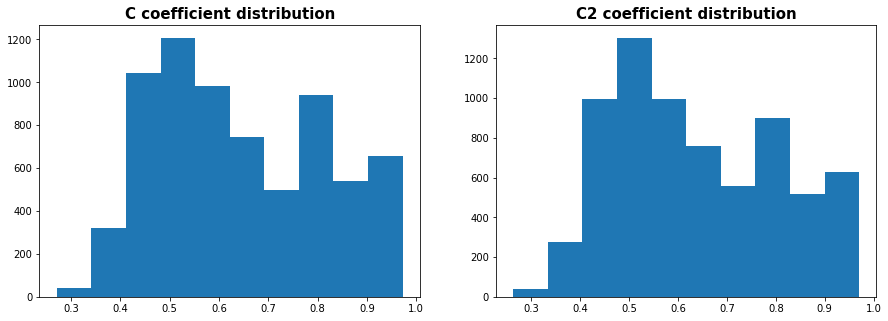

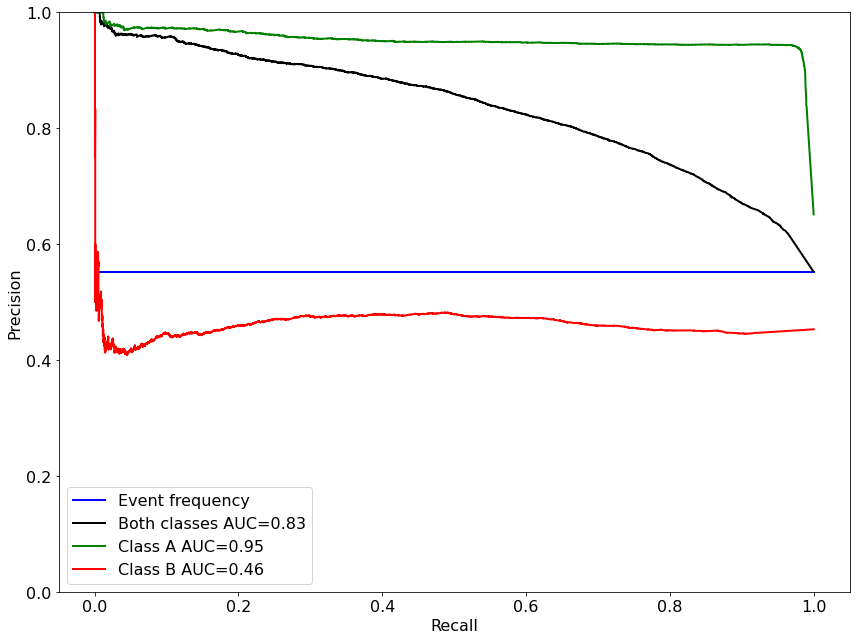

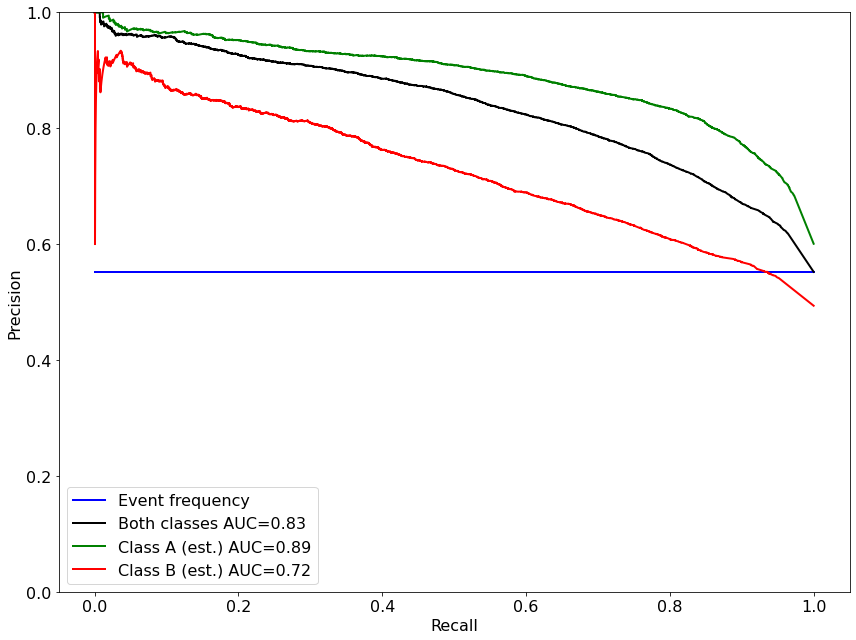

Accuracy for class A after 1 learning is : 0.786
Accuracy for class B after 1 learning is : 0.668


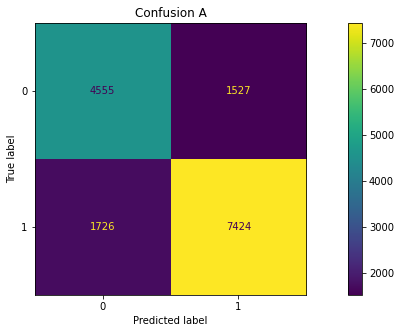

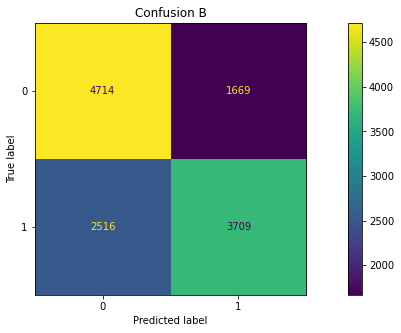

Accuracy after 1 learning is : 0.733
AUC unpredictable class 0.732
AUC predictable class 0.852
AUC both classes 0.807


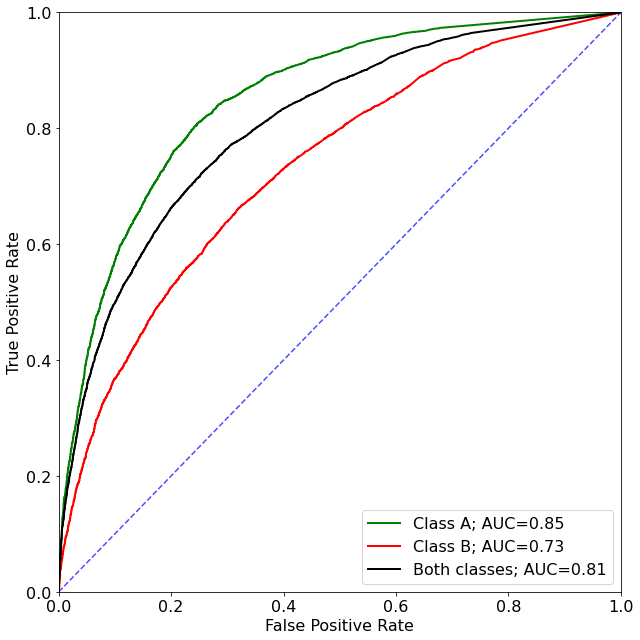

step # 1 ===week_test:8 week_train:12  week_test_2:16 week_upd:6 =========


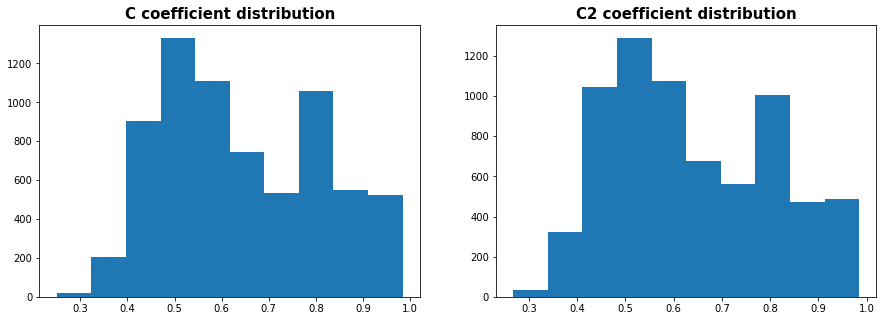

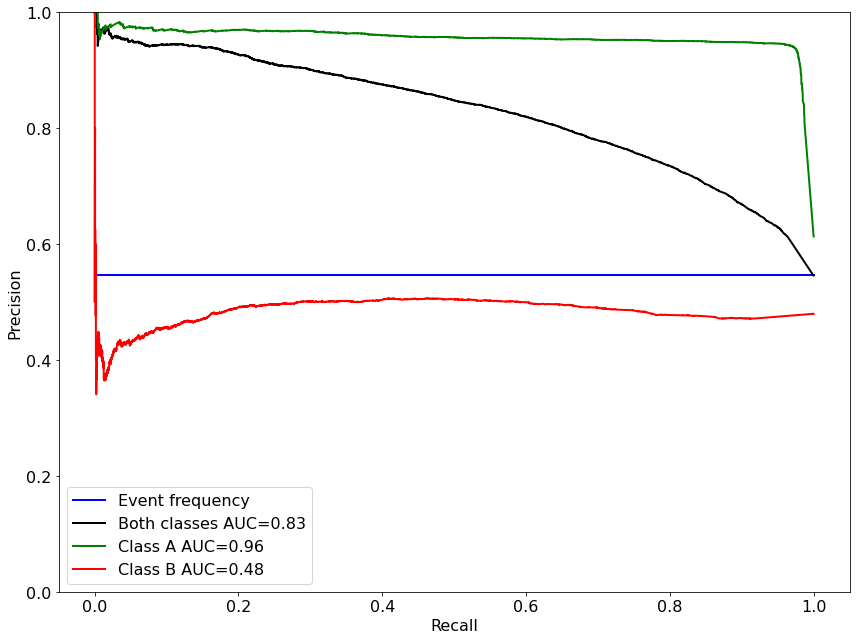

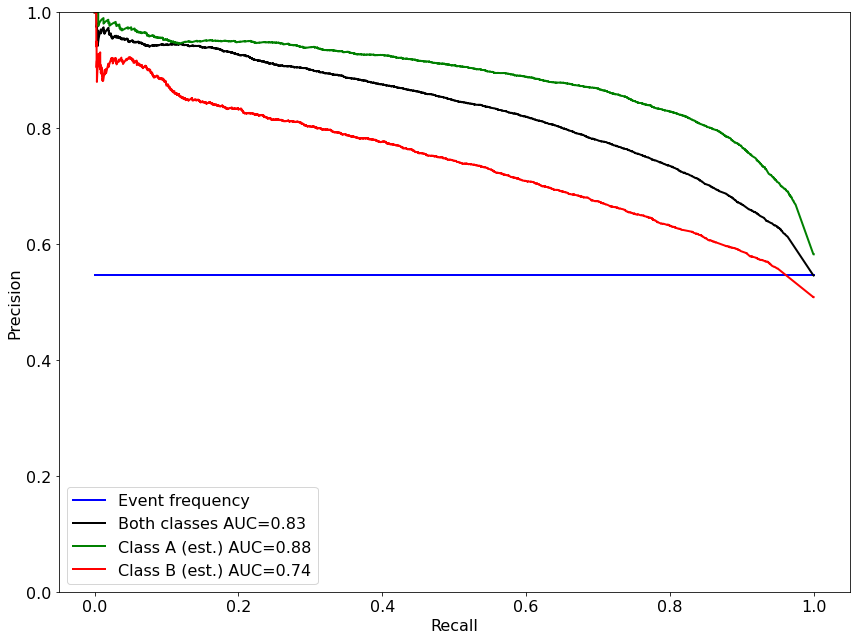

Accuracy for class A after 2 learning is : 0.782
Accuracy for class B after 2 learning is : 0.669


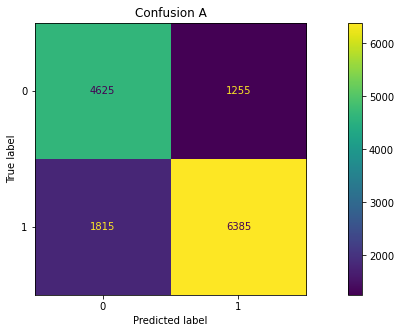

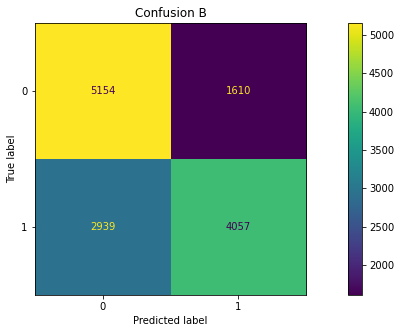

Accuracy after 2 learning is : 0.726
AUC unpredictable class 0.737
AUC predictable class 0.859
AUC both classes 0.806


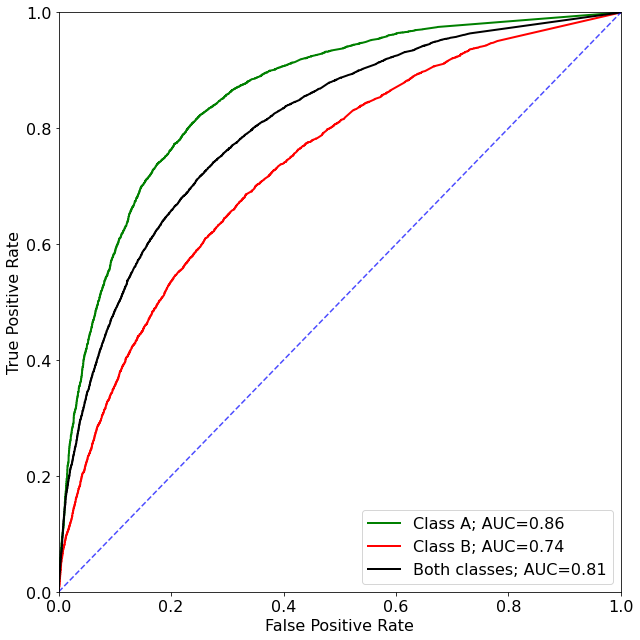

step # 2 ===week_test:10 week_train:14  week_test_2:18 week_upd:8 =========


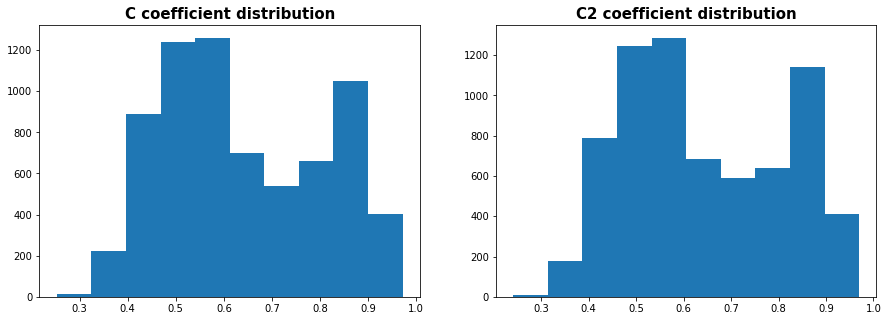

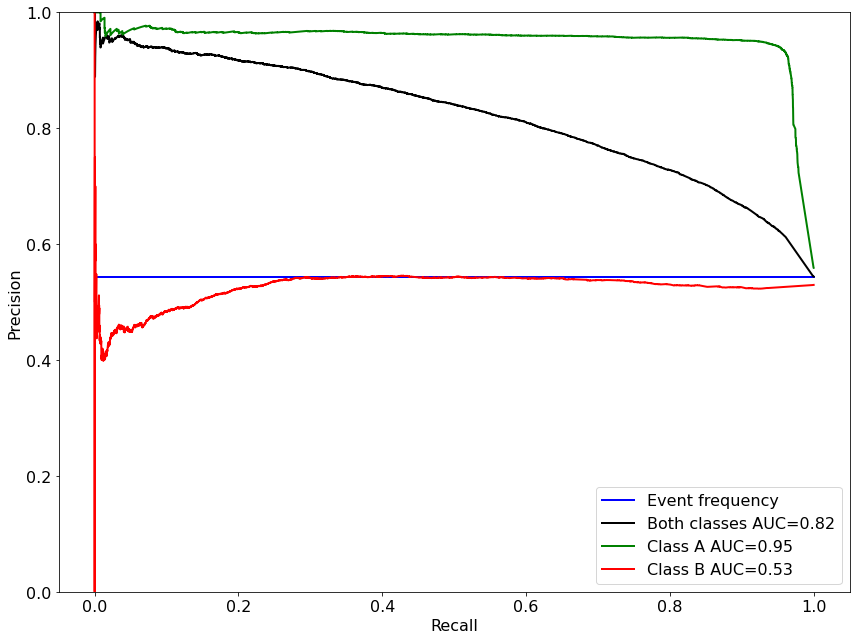

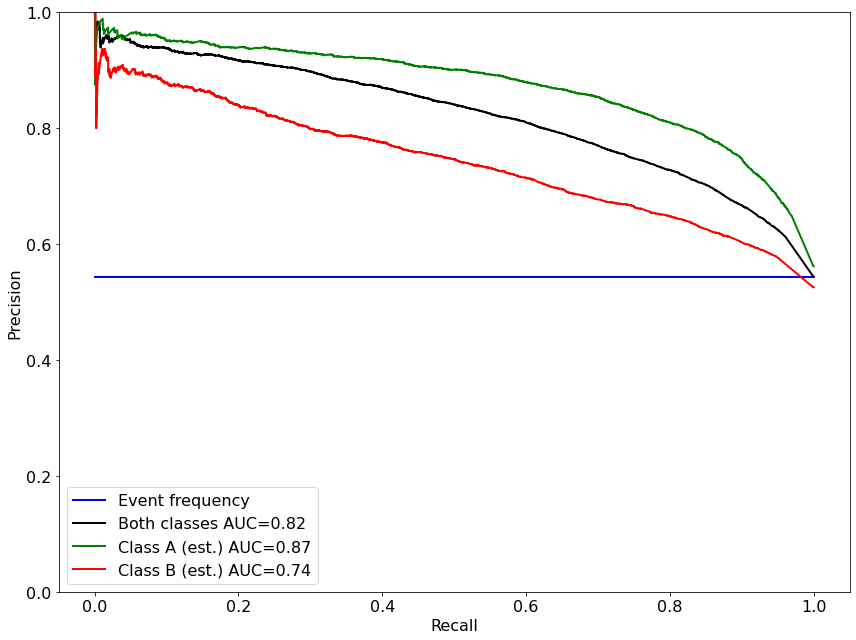

Accuracy for class A after 3 learning is : 0.766
Accuracy for class B after 3 learning is : 0.648


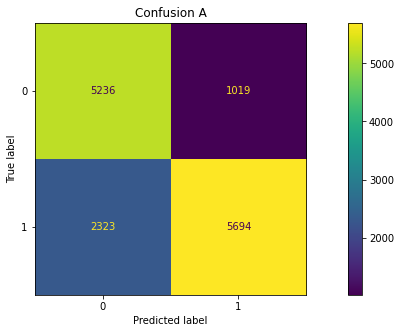

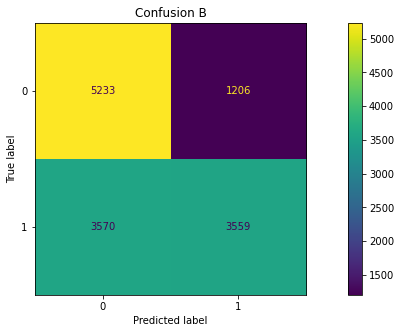

Accuracy after 3 learning is : 0.708
AUC unpredictable class 0.732
AUC predictable class 0.854
AUC both classes 0.801


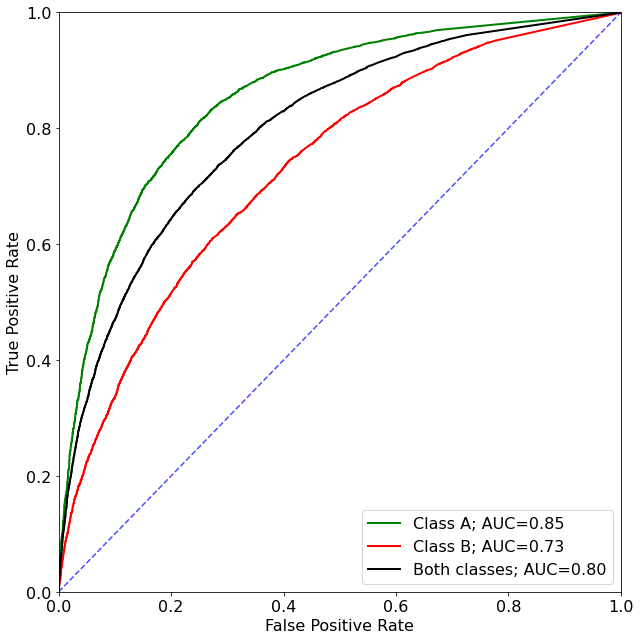

step # 3 ===week_test:12 week_train:16  week_test_2:20 week_upd:10 =========


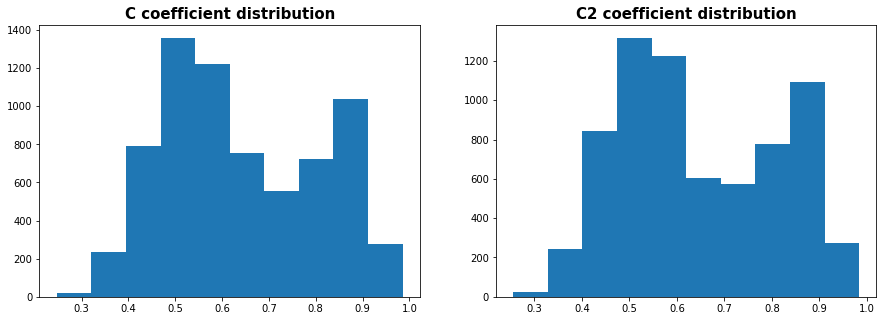

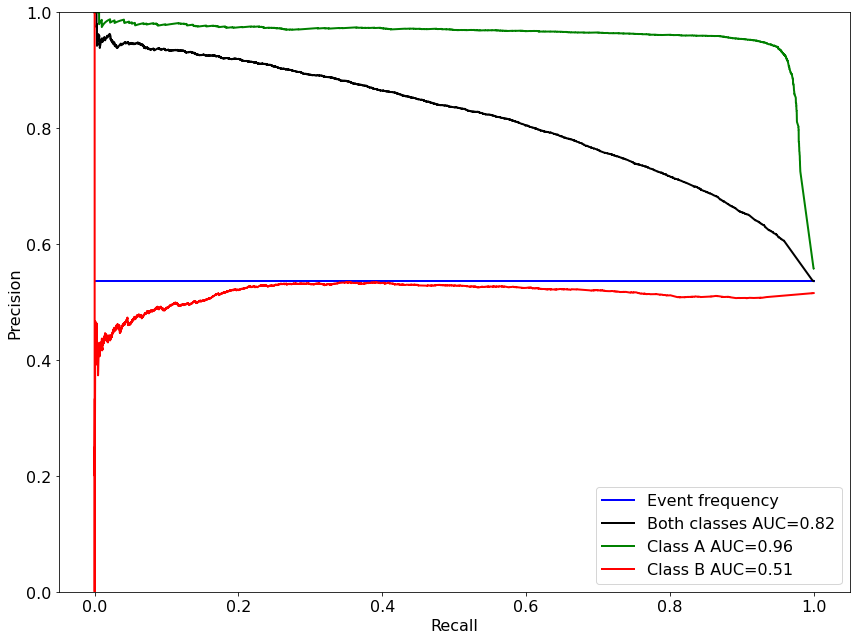

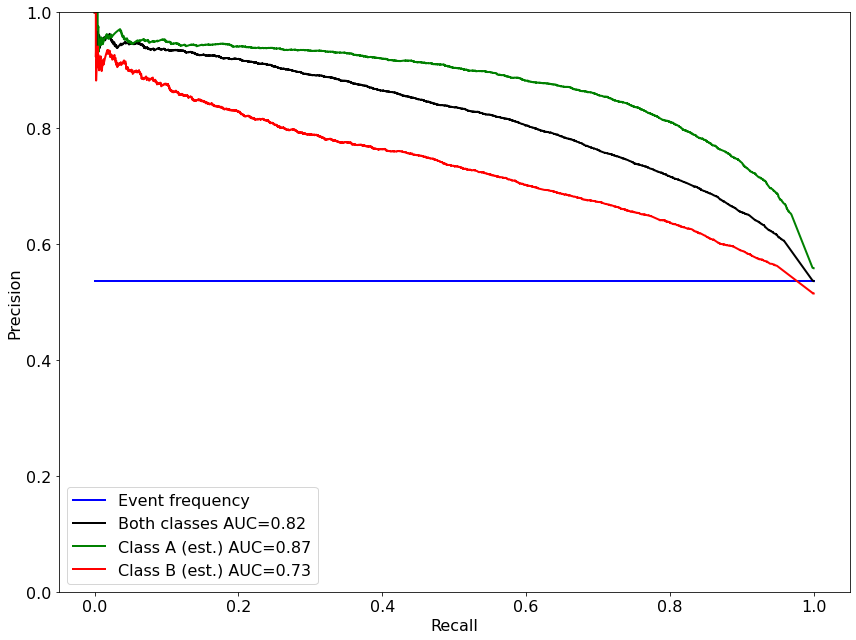

Accuracy for class A after 4 learning is : 0.778
Accuracy for class B after 4 learning is : 0.657


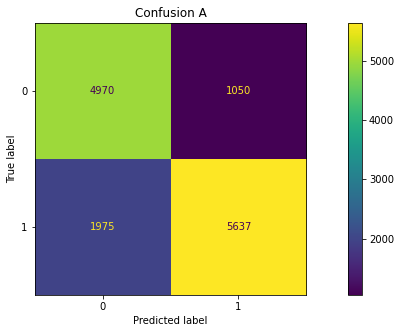

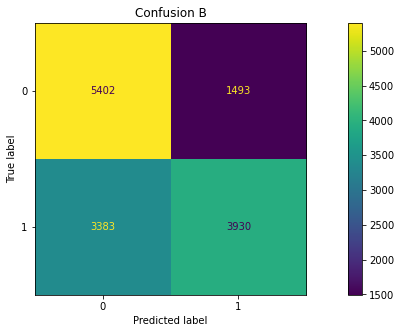

Accuracy after 4 learning is : 0.716
AUC unpredictable class 0.729
AUC predictable class 0.857
AUC both classes 0.798


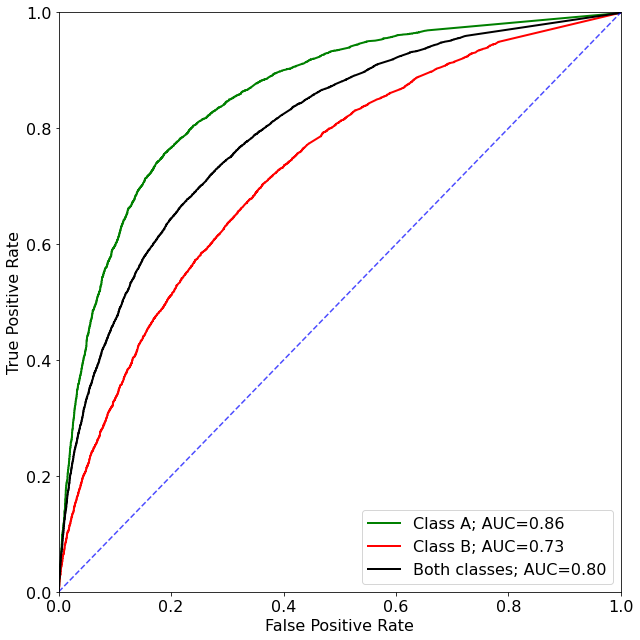

step # 4 ===week_test:14 week_train:18  week_test_2:22 week_upd:12 =========


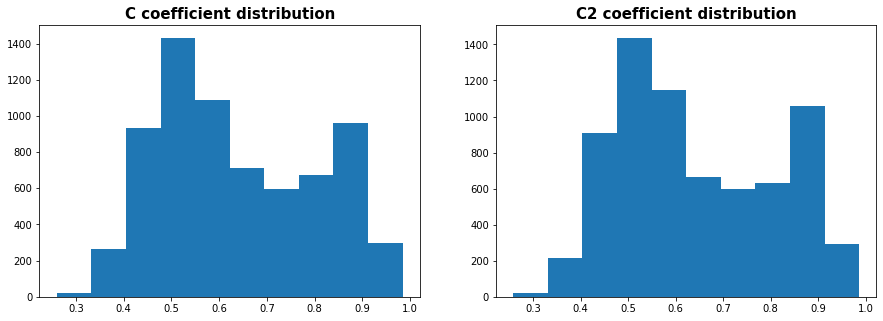

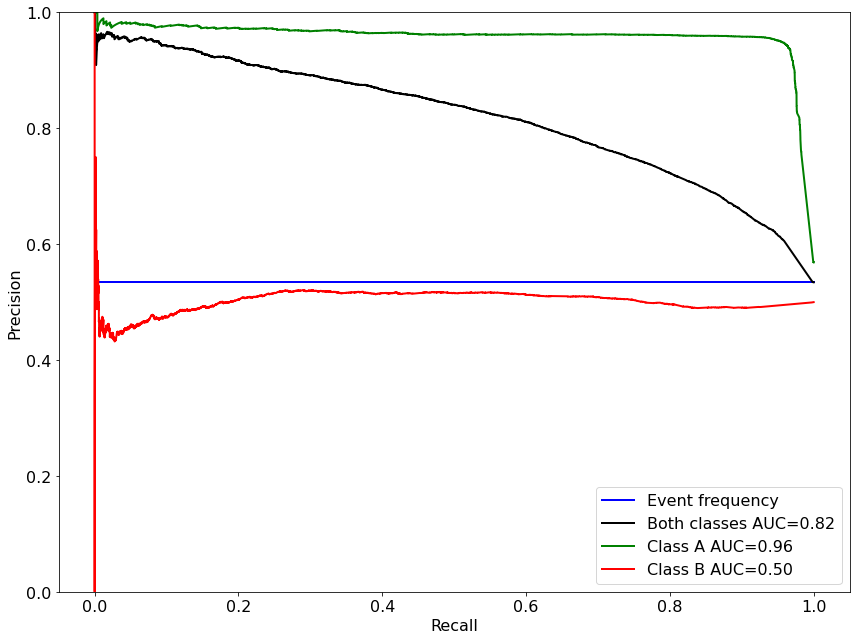

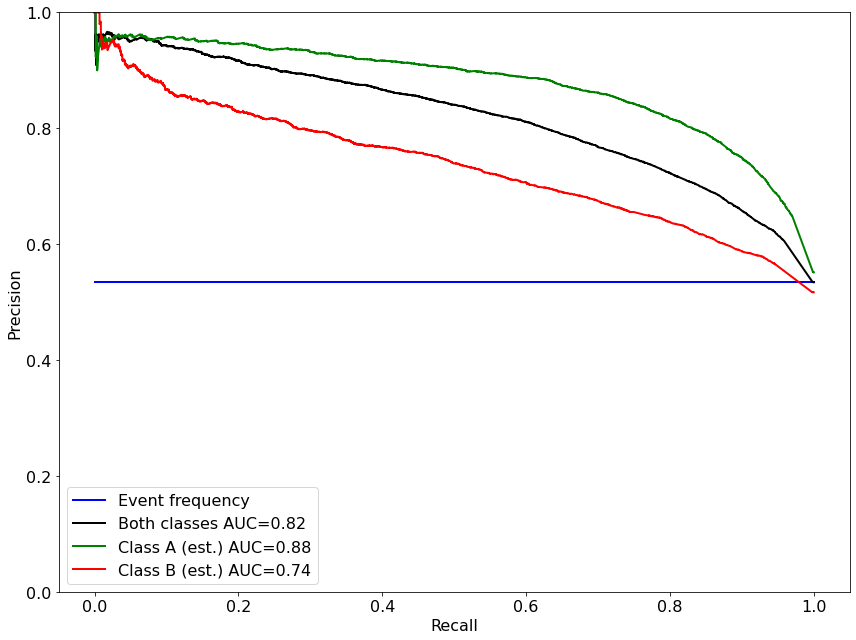

Accuracy for class A after 5 learning is : 0.782
Accuracy for class B after 5 learning is : 0.654


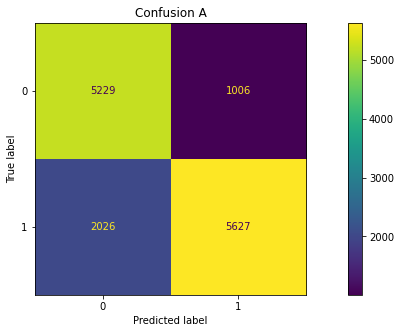

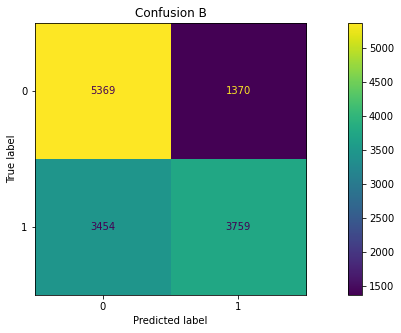

Accuracy after 5 learning is : 0.718
AUC unpredictable class 0.729
AUC predictable class 0.864
AUC both classes 0.803


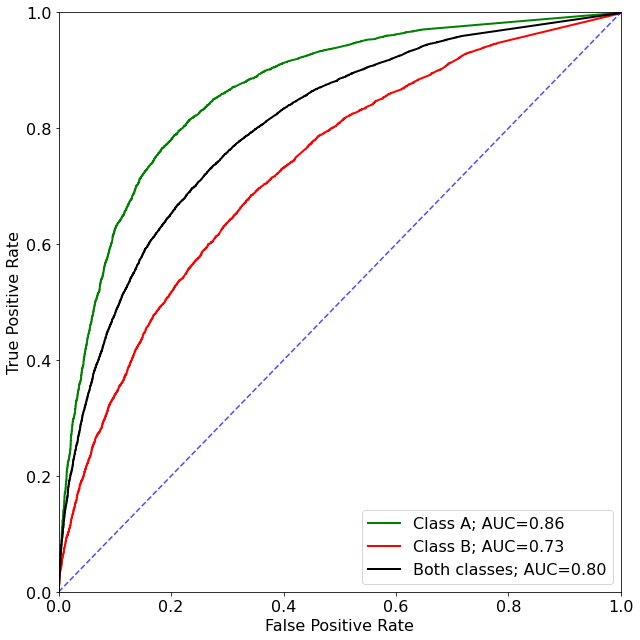

step # 5 ===week_test:16 week_train:20  week_test_2:24 week_upd:14 =========


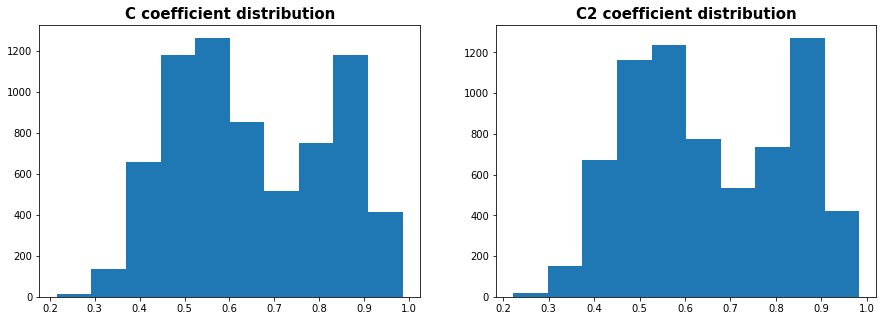

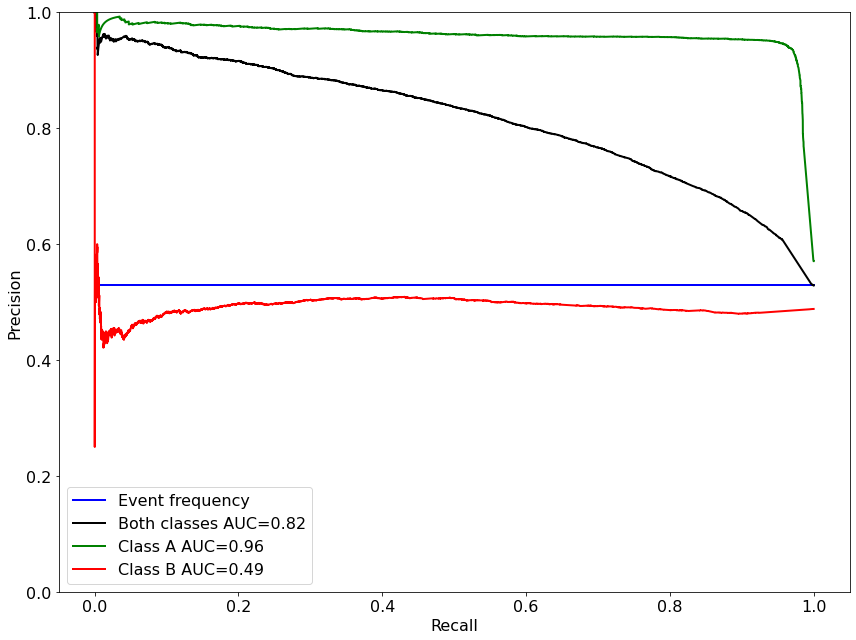

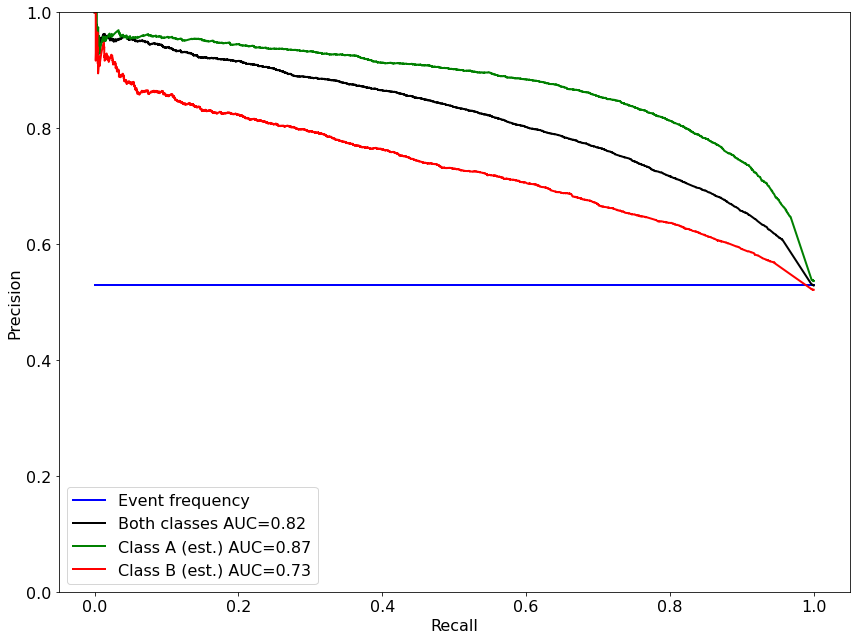

Accuracy for class A after 6 learning is : 0.791
Accuracy for class B after 6 learning is : 0.658


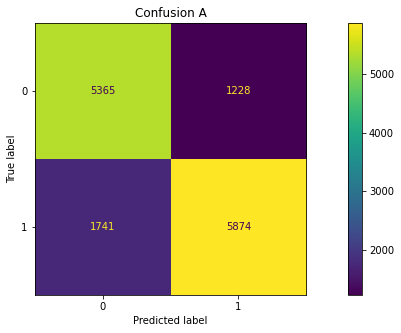

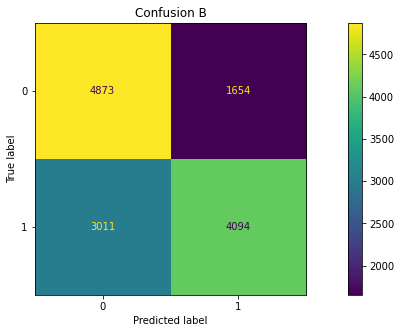

Accuracy after 6 learning is : 0.726
AUC unpredictable class 0.722
AUC predictable class 0.867
AUC both classes 0.804


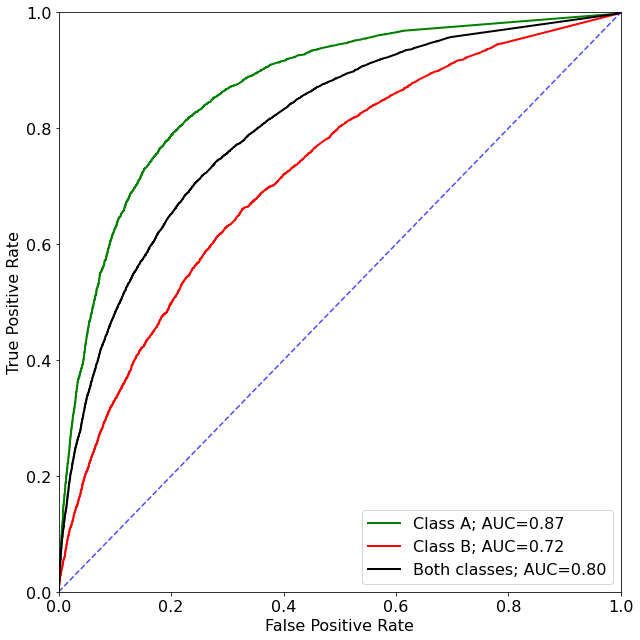

step # 6 ===week_test:18 week_train:22  week_test_2:26 week_upd:16 =========


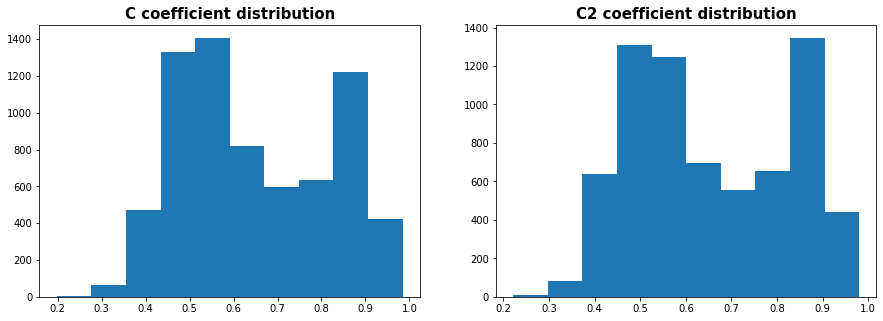

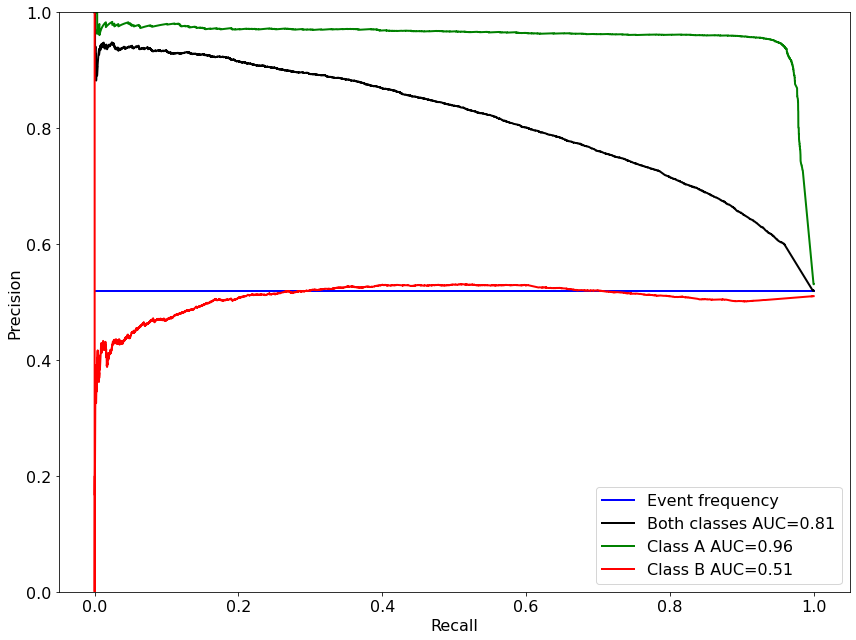

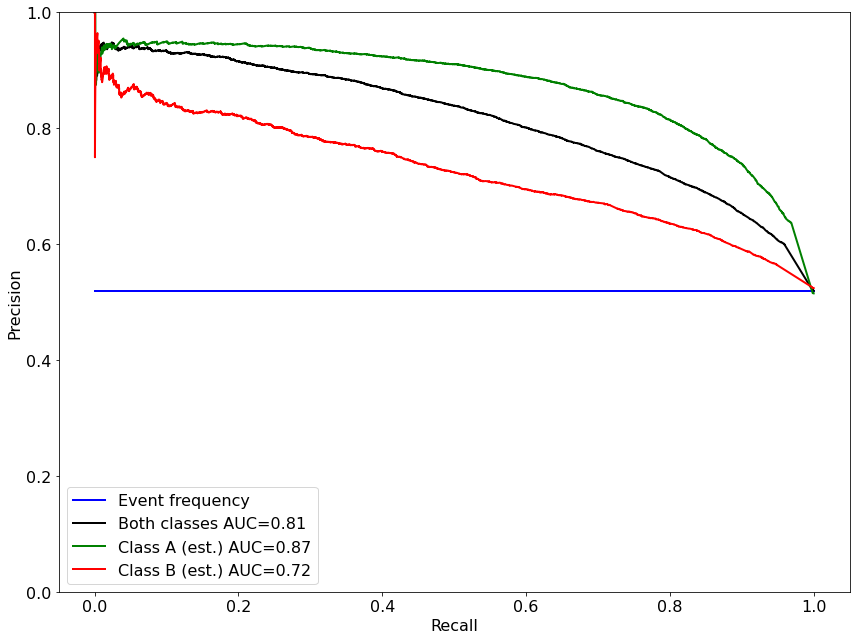

Accuracy for class A after 7 learning is : 0.795
Accuracy for class B after 7 learning is : 0.636


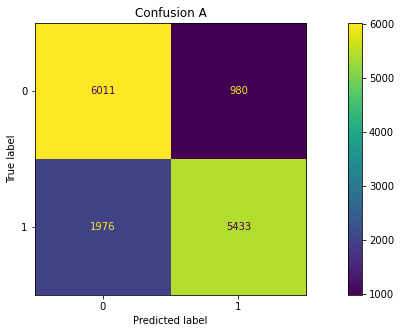

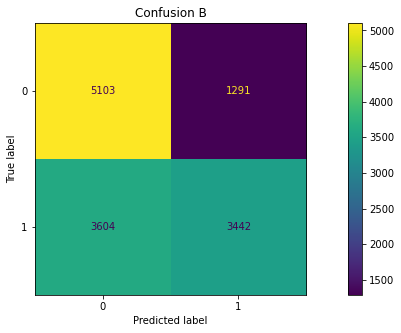

Accuracy after 7 learning is : 0.718
AUC unpredictable class 0.717
AUC predictable class 0.877
AUC both classes 0.809


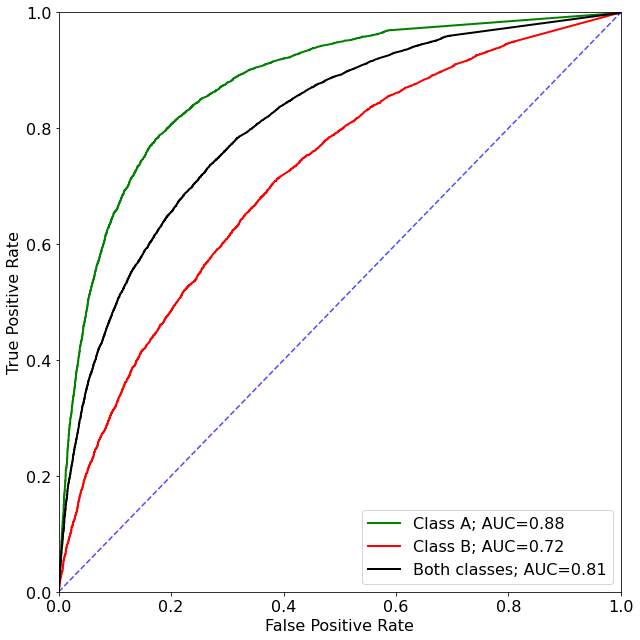

In [33]:
week_test = 6 - delta
week_train = 10 - delta
week_test_2 = 14 - delta
week_upd = week_test + delta
N_STEPS=9
NFILTERS = 64
BATCH_SIZE = 64
pred_cat = '60'
NCATS = table.shape[1] - 2
colors = ['k','g','r','g', 'r']
linestyles = ['-', '-', '-', '-', '-']
accA, accB, accTot=[],[],[]
for step in range(N_STEPS):
    K.clear_session()
    week_test = week_test + delta
    week_train = week_train + delta
    week_test_2 = week_test_2 + delta
    week_upd = week_test - delta
    if week_test_2 > ttab.last_week.max():
        break
    print('step # %i ===week_test:%i week_train:%i  week_test_2:%i week_upd:%i ========='%(step, 
                                            week_test, week_train, week_test_2, week_upd))
    if step==0:
        upd=False
    else:
        upd=True

    ind_test, ind_train, ind_test_2 = train_test_split_week(week_test, updating = upd)
    y_pred_LSTM, y_true_LSTM, y_pred_A, y_true_A, y_pred_B, y_true_B, y_pred_est_A, y_true_est_A, y_pred_est_B, y_true_est_B = infer(updating = upd)
    plt.rcParams["figure.figsize"] = [15, 5]
    plt.subplot(1,2,1)
    plt.hist(CE)
    plt.title('C coefficient distribution',size = 15,weight = 'bold')
    plt.subplot(1,2,2)
    plt.hist(CE2)
    plt.title('C2 coefficient distribution',size = 15,weight = 'bold')
    plt.show()       

    plt.rcParams["figure.figsize"] = [15, 5]

    freq=sum(y_true_LSTM)/len(y_true_LSTM)
    err_RNN = make_err_df(y_true_LSTM, y_pred_LSTM)
    err_RNN.name = 'Both classes'

    err_RNN_A = make_err_df(y_true_A, y_pred_A)
    err_RNN_A.name = 'Class A'

    err_RNN_B = make_err_df(y_true_B, y_pred_B)
    err_RNN_B.name = 'Class B'

    err_RNN_est_A = make_err_df(y_true_est_A, y_pred_est_A)
    err_RNN_est_A.name = 'Class A (est.)'

    err_RNN_est_B = make_err_df(y_true_est_B, y_pred_est_B)
    err_RNN_est_B.name = 'Class B (est.)'
    plt.figure(figsize=(12,9))
    plt.plot([0, 1], [freq, freq], label = 'Event frequency', linewidth=2, linestyle='-', color = 'b')
    recalls1 = plot_PRC([err_RNN, err_RNN_A, err_RNN_B], 0.5, colors, linestyles)#
    plt.tight_layout()
    plt.savefig(picdir+'PR_0_'+str(step)+'.png', dpi=300, format='png' )
    plt.show()
    plt.figure(figsize=(12,9))
    plt.plot([0, 1], [freq, freq], label = 'Event frequency', linewidth=2, linestyle='-', color = 'b')
    recalls2 = plot_PRC([err_RNN, err_RNN_est_A, err_RNN_est_B], 0.5, colors, linestyles)
    plt.tight_layout()
    plt.savefig(picdir+'PR_1_'+str(step)+'.png', dpi=300, format='png' )
    plt.show()
    
    y_pred_est_A1=data_for_matrix(y_pred_est_A,statistics.median(CE))
    confusion_matrix_est_A=confusion_matrix(y_true_est_A,y_pred_est_A1)
    accuracy1 = (confusion_matrix_est_A[0][0]+confusion_matrix_est_A[1][1])/(confusion_matrix_est_A[0][0]+confusion_matrix_est_A[1][0]+confusion_matrix_est_A[0][1]+confusion_matrix_est_A[1][1])
    print('Accuracy for class A after %i learning is : %.3f'%(step+1, accuracy1))

    y_pred_est_B1=data_for_matrix(y_pred_est_B,statistics.median(CE))
    confusion_matrix_est_B=confusion_matrix(y_true_est_B,y_pred_est_B1)
    accuracy2 = (confusion_matrix_est_B[0][0]+confusion_matrix_est_B[1][1])/(confusion_matrix_est_B[0][0]+confusion_matrix_est_B[1][0]+confusion_matrix_est_B[0][1]+confusion_matrix_est_B[1][1])
    print('Accuracy for class B after %i learning is : %.3f'%(step+1, accuracy2))

    dispA=ConfusionMatrixDisplay(confusion_matrix_est_A)
    dispB=ConfusionMatrixDisplay(confusion_matrix_est_B)
    dispA.plot()
    plt.title('Confusion A')
    dispB.plot()
    plt.title('Confusion B')
    plt.show()
    
    accuracy_classes_numenator = (confusion_matrix_est_B[0][0]+confusion_matrix_est_B[1][1]+confusion_matrix_est_A[0][0]+confusion_matrix_est_A[1][1])
    accuracy_classes_denumenator = (confusion_matrix_est_B[0][0]+confusion_matrix_est_B[1][0]+confusion_matrix_est_B[0][1]+confusion_matrix_est_B[1][1] + confusion_matrix_est_A[0][0]+confusion_matrix_est_A[1][0]+confusion_matrix_est_A[0][1]+confusion_matrix_est_A[1][1])
    accuracy_classes= accuracy_classes_numenator/accuracy_classes_denumenator
    print('Accuracy after %i learning is : %.3f'%(step+1, accuracy_classes))
    total_true_est = np.concatenate((y_true_est_A,y_true_est_B), axis=0)
    total_pred_est = np.concatenate((y_pred_est_A,y_pred_est_B), axis=0)

    accA.append(accuracy1)
    accB.append(accuracy2) 
    accTot.append(accuracy_classes)
    
    fpr_A, tpr_A, thresholds_A = metrics.roc_curve(y_true_est_A, y_pred_est_A, pos_label=1)
    roc_auc_A = metrics.auc(fpr_A, tpr_A)

    fpr_B, tpr_B, thresholds_B = metrics.roc_curve(y_true_est_B, y_pred_est_B, pos_label=1)
    roc_auc_B = metrics.auc(fpr_B, tpr_B)

    fpr, tpr, thresholds = metrics.roc_curve(total_true_est, total_pred_est, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)

    print('AUC unpredictable class',round(roc_auc_B,3))
    print('AUC predictable class',round(roc_auc_A,3))
    print('AUC both classes',round(roc_auc,3))

    plt.figure(figsize=(9,9))
    #plt.title('ROC AUC for both classes')  
    plt.plot(fpr_A, tpr_A, 'g', lw=2, label='Class A; AUC=%.2f'%roc_auc_A)
    plt.plot(fpr_B, tpr_B, 'r', lw=2, label='Class B; AUC=%.2f'%roc_auc_B)
    plt.plot(fpr, tpr, color='black', lw=2, label='Both classes; AUC=%.2f'%roc_auc)
    plt.plot([0, 1], [0, 1],'b--', alpha=0.7)
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate', size=16)
    plt.xlabel('False Positive Rate', size=16)
    plt.legend(fontsize=16)
    plt.tight_layout()
    plt.savefig(picdir+'ROC'+str(step)+'.png', dpi=300, format='png' )
    plt.show()

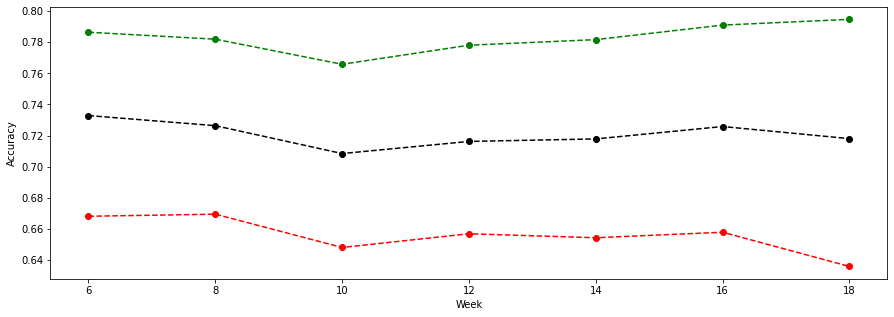

In [34]:
l=np.arange(len(accA))
plt.plot(accA, c='g', ls='--', label='class A', marker='o')
plt.plot(accB, c='r', ls='--', label='class B', marker='o')
plt.plot(accTot, c='black', ls='--', label='Both classes', marker='o')
plt.xlabel('Week')
plt.ylabel('Accuracy')
plt.xticks(l,2*l+6)
plt.show()